# Customer Age Determination

## EDA

### Import Libraries

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

### Data Loading and Sample Size

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
df_datagen = ImageDataGenerator(rescale=1./255)
df = df_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
features, target = next(df)

### Age Distribution

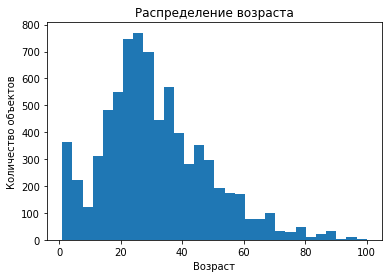

In [5]:
plt.hist(labels['real_age'], bins=30)
plt.xlabel('Age')
plt.ylabel('Number of Instances')
plt.title('Age Distribution')
plt.show()


From the distribution, we observe that the majority of instances in the dataset belong to the age group between 20 and 40 years. We also notice outliers in the 0-year age group; however, these instances might represent photos of infants rather than true outliers.

This distribution can impact the model's performance in a way that it may excel at identifying faces within the age range of 20 to 40 years better than, for example, the age range of 60 to 80 years. The model may be more accustomed to recognizing facial features and characteristics of individuals within the predominant age group in the dataset. It is important to consider this bias while interpreting the model's predictions and assessing its overall accuracy across different age ranges.

### Dataset Structure

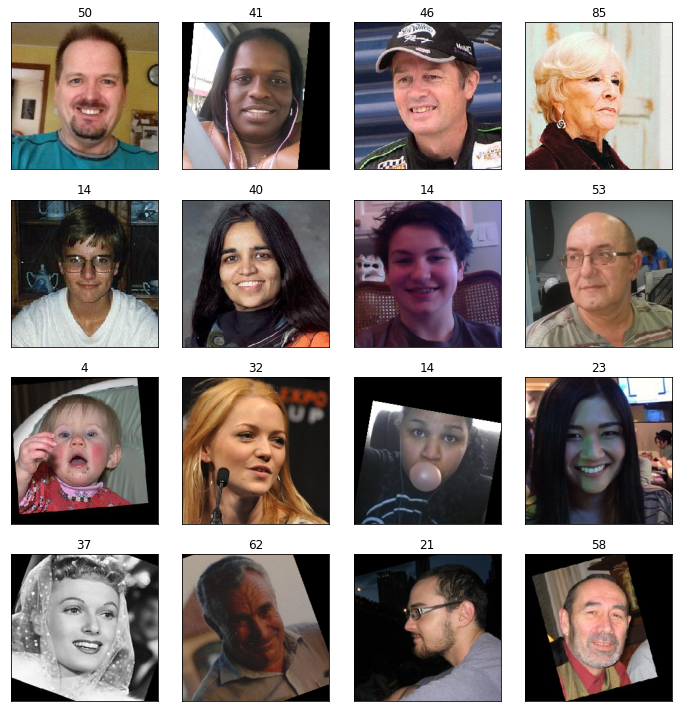

In [6]:
fig = plt.figure(figsize=(10,10))
for i in range (16):
    fig.add_subplot(4,4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])

After loading the data and analyzing the images, we can draw the following conclusions:

- The larger the amount of data available for model training, the better the model can learn and make predictions on new images. With a dataset of 7,591 images, we have a sufficient amount of data that is likely to prevent model overfitting, and there is no need for data freezing during training.
- The images in the dataset are of relatively high quality, and they have been properly labeled. However, to improve the training of our ResNet50 model, it would be beneficial to perform data augmentation techniques such as horizontal flipping. This will provide additional variations in the dataset, resulting in a more robust and accurate model.

By performing data augmentation and incorporating high-quality images into the training process, we can enhance the performance of the ResNet50 model in accurately predicting the approximate age of individuals based on their photos.

## Model training 

```python
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
```

```python
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
 
    return train_gen_flow
```

```python
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
```

```python
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, include_top=False,
                       weights='imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
 
    return model
```

```python
def train_model(model, train_datagen_flow, test_gen_flow, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_datagen_flow,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - 59s - loss: 211.9130 - mae: 11.0453 - val_loss: 396.0615 - val_mae: 14.9286

Epoch 2/10

356/356 - 47s - loss: 124.9848 - mae: 8.5565 - val_loss: 1138.9759 - val_mae: 29.3400

Epoch 3/10

356/356 - 46s - loss: 92.6442 - mae: 7.3881 - val_loss: 141.9806 - val_mae: 9.0763

Epoch 4/10

356/356 - 47s - loss: 67.6435 - mae: 6.3575 - val_loss: 114.9930 - val_mae: 8.4154

Epoch 5/10

356/356 - 45s - loss: 46.5019 - mae: 5.2894 - val_loss: 123.5778 - val_mae: 8.2513

Epoch 6/10

356/356 - 46s - loss: 32.4408 - mae: 4.3679 - val_loss: 150.3791 - val_mae: 9.0532

Epoch 7/10

356/356 - 45s - loss: 27.3576 - mae: 4.0127 - val_loss: 92.4920 - val_mae: 7.1208

Epoch 8/10

356/356 - 45s - loss: 21.1979 - mae: 3.5681 - val_loss: 80.7678 - val_mae: 6.8319

Epoch 9/10

356/356 - 44s - loss: 18.0197 - mae: 3.2388 - val_loss: 101.8166 - val_mae: 7.3434

Epoch 10/10

356/356 - 41s - loss: 17.2753 - mae: 3.2205 - val_loss: 94.4991 - val_mae: 7.4169

## Analysis of the Trained Model



- During the data exploration and analysis, we discovered that the main portion of the dataset consists of images of people in the age range of 20 to 40 years. Some of the images were horizontally tilted, which required us to use the ImageDataGenerator during the model training process.

- We chose the ResNet architecture for its high performance in training and its popularity in computer vision tasks. The deep layers of ResNet allow the model to capture intricate features and patterns, making it suitable for age estimation from images.

- After training the model, we achieved a mean absolute error (MAE) of 3.22 on the training dataset and 7.41 on the testing dataset. The lower MAE value on the training dataset indicates that the model is able to better predict the age of the individuals it was trained on. However, it is important to note that the higher MAE value on the testing dataset suggests that the model may have some difficulty generalizing to unseen data.

- Further analysis and evaluation of the model's performance can be conducted to identify areas of improvement, such as fine-tuning the model architecture, adjusting hyperparameters, or collecting a more diverse dataset that covers a wider age range.